# Analyze Weights&Bias Hyperparameter Search Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple
from scipy.stats import kruskal
import os
from pathlib import Path
from scikit_posthocs import posthoc_dunn

In [2]:
project_root = "../.."
plot_path = os.path.join(project_root, "results", "experiments", "related_data")
Path(plot_path).mkdir(exist_ok=True, parents=True)


In [3]:
change_runs = {
    "node_type": {
        "pretrained_model": {
            "Binding_DDG": "residue",
            "DeepRefine": "atom"
        }
    },
    "learning_rate": {
        "batch_size": "divide"
    },
    "batch_size": {
        "node_type": {
            "atom": ("divide", 5)
        }
    },    
    "max_num_nodes": {
        "node_type": {
            "atom": ("multiply", 5)
        }
    }
    
}

remove_runs = {
    "attention_heads": {
        "layer_type": "GCN",
        "num_gnn_layers": 0
    },
    "gnn_type": {
        "num_gnn_layers": 0
    },
    "channel_halving": {
        "num_gnn_layers": 0
    },
    "channel_doubling": {
        "num_gnn_layers": 0
    },
    
}

def change_value(row: pd.Series, original_col: str, adaption_dict: Dict):
    for key, adaptions in adaption_dict.items():
        if isinstance(adaptions, str):
            if adaptions == "divide":
                row[original_col] / row[key]
        elif isinstance(adaptions, Dict) and key in row and row[key] in adaptions:
            if isinstance(adaptions[row[key]], str):
                return adaptions[row[key]]
            elif isinstance(adaptions[row[key]], Tuple):
                if adaptions[row[key]][0] == "divide":
                    row[original_col] / adaptions[row[key]][1]
                elif adaptions[row[key]][0] == "multiply":
                    row[original_col] * adaptions[row[key]][1]
    
    return row[original_col]


def remove_rows(row: pd.Series, original_col: str, remove_dict: Dict):
    for key, value in remove_dict.items():
        if row[key] == value:
            return False

    return True


def select_df(df: pd.DataFrame, target: str, group: str, x_min: int = None, x_max: int = None):
    if x_min is not None:
        df = df[df[target] >= x_min].copy()
    if x_max is not None:
        df = df[df[target] <= x_max].copy()
    
    for col, adaption in change_runs.items():
        if group != col:
            continue
        df[col] = df.apply(lambda row: change_value(row, col, adaption), axis=1)
    for col, remove in remove_runs.items():
        if group != col:
            continue
        df = df[df.apply(lambda row: remove_rows(row, col, remove), axis=1)].copy()
        
    df = df[["Name", target, group]]

    return df[["Name", target, group]]


def plot_box_plot(df: pd.DataFrame, target: str, group: str, x_min: int = None, x_max: int = None, axis = None,
                 rotate_x_labels: bool = False, order=None):
    mapping = {
        target: " ".join([x.capitalize() for x in target.split(":")[1].split("_")]) + " [-log(Kd)]",
        group: " ".join([x.capitalize() for x in group.split("_")])
    }
    df = select_df(df, target, group, x_min, x_max)
    df = df.rename(mapping, axis=1, copy=True)
    
    if axis is not None:
        plot = sns.boxplot(data=df, y=mapping[target], x=mapping[group], ax=axis, order=order)
    else:
        plot = sns.boxplot(data=df, y=mapping[target], x=mapping[group], order=order)
        plt.show()
    
    if rotate_x_labels:
        plt.setp(plot.get_xticklabels(), rotation=45, ha="right")


def calc_kruskal_wallis_score(df: pd.DataFrame, target: str, group: str, x_min: int = None, x_max: int = None):
    mapping = {
            target: " ".join([x.capitalize() for x in target.split(":")[1].split("_")]),
            group: " ".join([x.capitalize() for x in group.split("_")])
    }
    df = select_df(df, target, group, x_min, x_max)
    df = df.rename(mapping, axis=1)

    group_values = []
    results = []

    groups = df.groupby(mapping[group]).groups

    for value, idx in groups.items():
        group_values.append(value)
        results.append(df.loc[idx, mapping[target]])

    kruskal_results = kruskal(*results)
    print(f"Kruskal results for parameter {mapping[group]}: H={kruskal_results[0]}, p_value={kruskal_results[1]}  ")

    #if kruskal_results[1] < 0.05:
    # perform posthoc analyis
    posthoc_results = posthoc_dunn(df, val_col=mapping[target], group_col=mapping[group])
    #print("\tResults of Posthoc analysis with Bonferri correction")
    #print(posthoc_results < 0.05)
        
    return kruskal_results, group_values, posthoc_results

In [4]:
TARGET_VALUE = "abag_affinity:absolute_val_rmse"

## Exploratory Hyperparameter Search

In [5]:
results_filepath = "/home/fabian/Desktop/Uni/Masterthesis/ag_binding_affinity/results/related_data_results.csv"
results_df = pd.read_csv(results_filepath)
results_df.loc[ results_df["train_strategy"] == "model_train", "transfer_learning_datasets"] = "no_dataset"
results_df.head()

,Name,State,Created,Runtime,ID,transfer_learning_datasets,train_strategy,abag_affinity:absolute_val_rmse,abag_affinity:absolute_val_loss,abag_affinity:absolute_val_corr,DMS-madan21_mutat_hiv:relative_val_acc,DMS-madan21_mutat_hiv:relative_val_corr,DMS-mason21_comb_optim_therap_antib_by_predic_combined_L3_3:relative_val_acc,DMS-wu17_in:relative_val_acc,DMS-wu17_in:relative_val_corr,DMS-wu17_in:relative_val_loss,DMS-wu17_in:relative_val_rmse,DMS-mason21_optim_therap_antib_by_predic_dms_H:relative_val_acc,PDBBind:absolute_val_acc
0,splendid-sweep-5,finished,2023-02-09T08:05:26.000Z,1660,6qirrsl2,DMS-b.20_funct_screen_strat_engin_chimer:relative,bucket_train,1.289052,1.661655,0.368207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,giddy-sweep-28,finished,2023-02-14T13:41:24.000Z,79,85ua9myw,DMS-b.20_funct_screen_strat_engin_chimer:relative,bucket_train,1.536866,0.008173,0.077501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hearty-sweep-26,finished,2023-02-11T12:31:24.000Z,1199,nwneqx20,DMS-b.20_funct_screen_strat_engin_chimer:relative,bucket_train,1.390536,1.057627,0.141907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,balmy-sweep-23,finished,2023-02-11T11:48:10.000Z,311,6odmtx0c,DMS-madan21_mutat_hiv:relative,bucket_train,1.252540,1.568856,0.417249,0.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,stilted-sweep-47,finished,2023-02-20T14:32:02.000Z,80,7mny23j0,DMS-madan21_mutat_hiv:relative,bucket_train,1.369051,0.005785,0.201288,0.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print("Number of runs: ", len(results_df))

Number of runs:  44


In [7]:
# Add random runs without any related dataset from the GNN hyperparameter search
gnn_results_filepath = "/home/fabian/Desktop/Uni/Masterthesis/ag_binding_affinity/results/exploratory_gnn_hyperparameter_search_results.csv"
gnn_results_df = pd.read_csv(gnn_results_filepath)
gnn_results_df["transfer_learning_datasets"] = "no_dataset"
gnn_results_df["train_strategy"] = "model_train"
sample_runs = gnn_results_df.sample(n=20, random_state=123)
results_df = pd.concat([results_df, sample_runs])

In [8]:
hyperparameters = ["transfer_learning_datasets", "train_strategy"]

In [9]:
for parameter in hyperparameters:
    print(results_df[parameter].value_counts())

no_dataset                                                              21
SKEMPI.v2:absolute                                                       7
DMS-madan21_mutat_hiv:relative                                           6
DMS-mason21_comb_optim_therap_antib_by_predic_combined_H3_3:relative     4
DMS-mason21_comb_optim_therap_antib_by_predic_combined_L3_3:relative     4
DMS-b.20_funct_screen_strat_engin_chimer:relative                        3
DMS-mason21_optim_therap_antib_by_predic_dms_H:relative                  3
DMS-mason21_optim_therap_antib_by_predic_dms_L:relative                  3
DMS-phillips21_bindin:absolute                                           3
PDBBind:absolute                                                         3
SKEMPI.v2:relative                                                       3
DMS-phillips21_bindin:relative                                           2
DMS-wu17_in:relative                                                     2
Name: transfer_learning_d

In [10]:
parameter = "transfer_learning_datasets"
results_df[results_df[TARGET_VALUE] < 2].groupby(by=parameter)[TARGET_VALUE].describe()

,count,mean,std,min,25%,50%,75%,max
transfer_learning_datasets,,,,,,,,
DMS-b.20_funct_screen_strat_engin_chimer:relative,3.0,1.405485,0.124582,1.289052,1.339794,1.390536,1.463701,1.536866
DMS-madan21_mutat_hiv:relative,6.0,1.417177,0.114558,1.252540,1.370425,1.394934,1.494164,1.571161
DMS-mason21_comb_optim_therap_antib_by_predic_combined_H3_3:relative,3.0,1.403509,0.027441,1.375712,1.389974,1.404235,1.417407,1.430580
DMS-mason21_comb_optim_therap_antib_by_predic_combined_L3_3:relative,4.0,1.503754,0.173792,1.347737,1.427057,1.457334,1.534031,1.752613
DMS-mason21_optim_therap_antib_by_predic_dms_H:relative,3.0,1.365711,0.018163,1.347559,1.356624,1.365688,1.374787,1.383886
DMS-mason21_optim_therap_antib_by_predic_dms_L:relative,3.0,1.384754,0.083933,1.336204,1.336296,1.336388,1.409030,1.481671
DMS-phillips21_bindin:absolute,2.0,1.479902,0.138483,1.381979,1.430940,1.479902,1.528863,1.577824
DMS-phillips21_bindin:relative,1.0,1.352681,NaN,1.352681,1.352681,1.352681,1.352681,1.352681
DMS-wu17_in:relative,2.0,1.597617,0.176789,1.472608,1.535112,1.597617,1.660121,1.722625


In [11]:
parameter = "train_strategy"
results_df[results_df[TARGET_VALUE] < 2].groupby(by=parameter)[TARGET_VALUE].describe()

,count,mean,std,min,25%,50%,75%,max
train_strategy,,,,,,,,
bucket_train,19.0,1.435172,0.146084,1.252540,1.347648,1.378059,1.483723,1.817488
model_train,19.0,1.454567,0.148682,1.280279,1.359317,1.400437,1.501801,1.811761
pretrain_model,21.0,1.444998,0.148990,1.329062,1.365231,1.381979,1.472608,1.922851


In [12]:
results_df[results_df[TARGET_VALUE] < 2].groupby(by=parameter)["Runtime"].describe() / 60

,count,mean,std,min,25%,50%,75%,max
train_strategy,,,,,,,,
bucket_train,0.316667,22.692105,35.877315,0.916667,4.108333,10.633333,25.741667,159.566667
model_train,0.316667,19.613158,12.136976,4.066667,10.600000,17.633333,24.416667,51.266667
pretrain_model,0.350000,897.823016,2909.234597,5.150000,10.066667,16.583333,40.400000,13140.033333


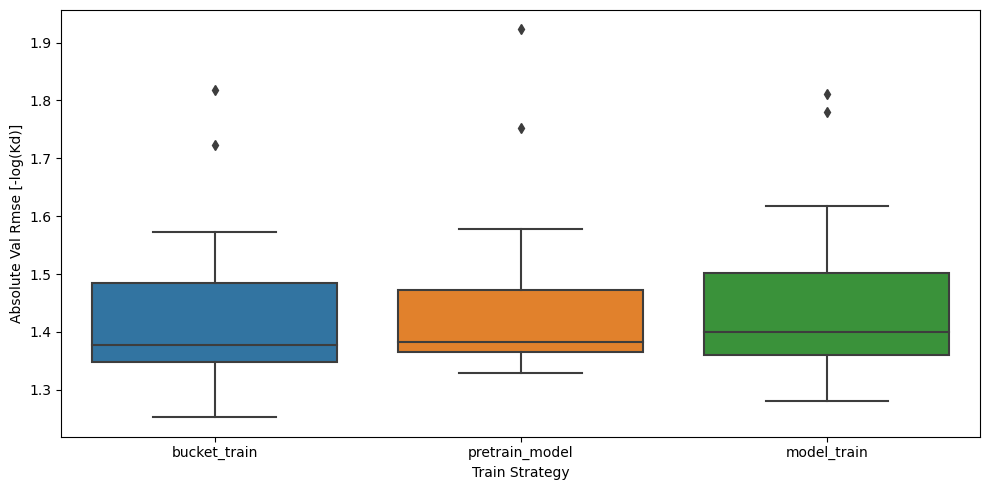

In [13]:
parameter = "train_strategy"
fig, ax = plt.subplots(figsize=(10,5))

order = results_df[results_df[TARGET_VALUE] <= 2].groupby(by=[parameter])[TARGET_VALUE].median().sort_values().index

parameter_df = results_df[results_df[parameter] != ""]
plot_box_plot(parameter_df, TARGET_VALUE, parameter, x_min=None, x_max=2, axis=ax, order=order, rotate_x_labels=parameter=="transfer_learning_datasets")

fig.tight_layout()
plt.savefig(os.path.join(plot_path, "train_strategy_boxplot.png"))
plt.show()

In [14]:
results_df[results_df[TARGET_VALUE] <= 2].groupby(by=[parameter])[TARGET_VALUE].median().sort_values()

train_strategy
bucket_train      1.378059
pretrain_model    1.381979
model_train       1.400437
Name: abag_affinity:absolute_val_rmse, dtype: float64

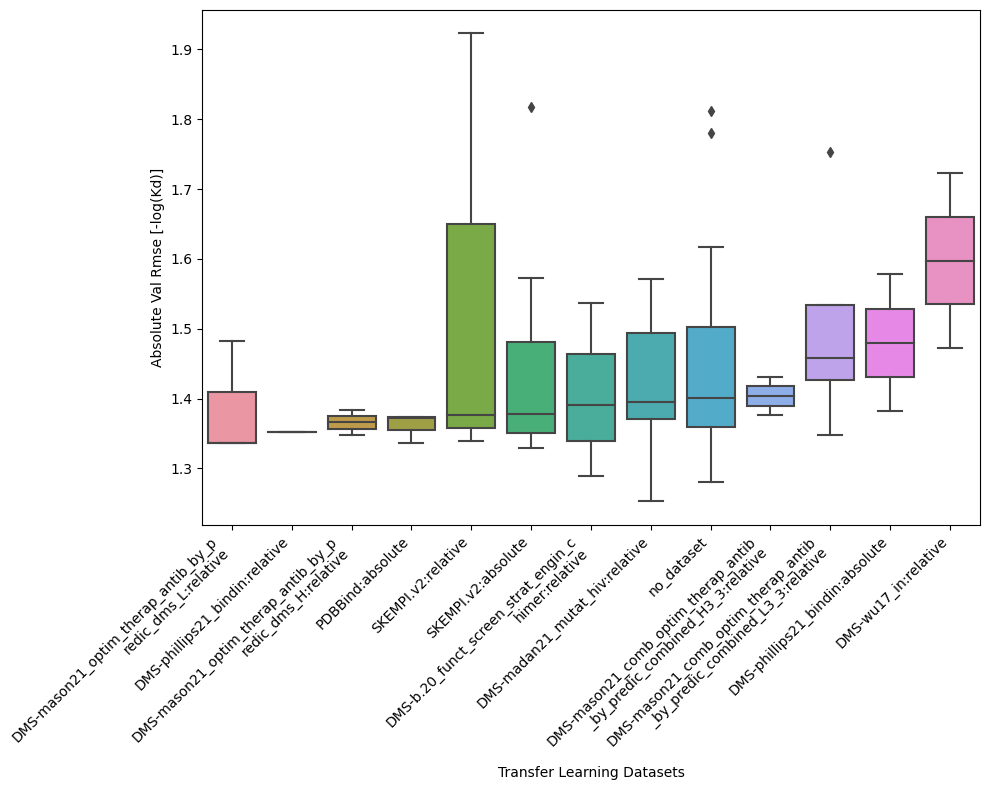

In [15]:
import textwrap

max_width = 35

parameter = "transfer_learning_datasets"
fig, ax = plt.subplots(figsize=(10,8))

order = results_df[results_df[TARGET_VALUE] <= 2].groupby(by=[parameter])[TARGET_VALUE].median().sort_values().index

parameter_df = results_df[results_df[parameter] != ""]
plot_box_plot(parameter_df, TARGET_VALUE, parameter, x_min=None, x_max=2, axis=ax, order=order,rotate_x_labels=parameter=="transfer_learning_datasets")


ax.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())

fig.tight_layout()
plt.savefig(os.path.join(plot_path, "related_data_boxplot.png"))
plt.show()

In [16]:
rows = []
posthoc_results = {}

for i, parameter in enumerate(hyperparameters):
    (h, p), parameter_values, posthoc_result = calc_kruskal_wallis_score(results_df, TARGET_VALUE, parameter, x_min=None, x_max=10000000)
    rows.append({
        "Hyperparameter": parameter,
        "Values": parameter_values,
        "Kruskal H-score": h,
        "Kruskal p_value": p,
        "significant_difference": p < 0.05
    })
    posthoc_results[parameter] = posthoc_result
    print()
    
parameter_comparison_df = pd.DataFrame(rows)

Kruskal results for parameter Transfer Learning Datasets: H=10.691503443341404, p_value=0.5555254313330684  

Kruskal results for parameter Train Strategy: H=1.541923511638104, p_value=0.4625679768674341  



In [17]:
posthoc_results["transfer_learning_datasets"].loc["no_dataset"]

DMS-b.20_funct_screen_strat_engin_chimer:relative                       0.601731
DMS-madan21_mutat_hiv:relative                                          0.590061
DMS-mason21_comb_optim_therap_antib_by_predic_combined_H3_3:relative    0.889532
DMS-mason21_comb_optim_therap_antib_by_predic_combined_L3_3:relative    0.700590
DMS-mason21_optim_therap_antib_by_predic_dms_H:relative                 0.254024
DMS-mason21_optim_therap_antib_by_predic_dms_L:relative                 0.230312
DMS-phillips21_bindin:absolute                                          0.223836
DMS-phillips21_bindin:relative                                          0.707195
DMS-wu17_in:relative                                                    0.281938
PDBBind:absolute                                                        0.159785
SKEMPI.v2:absolute                                                      0.551684
SKEMPI.v2:relative                                                      0.866301
no_dataset                  

In [18]:
posthoc_results["train_strategy"]

,bucket_train,model_train,pretrain_model
bucket_train,1.000000,0.388011,0.489055
model_train,0.388011,1.000000,0.845416
pretrain_model,0.489055,0.845416,1.000000


In [19]:
parameter_comparison_df

,Hyperparameter,Values,Kruskal H-score,Kruskal p_value,significant_difference
0,transfer_learning_datasets,[DMS-b.20_funct_screen_strat_engin_chimer:rela...,10.691503,0.555525,False
1,train_strategy,"[bucket_train, model_train, pretrain_model]",1.541924,0.462568,False


In [20]:
print(parameter_comparison_df.to_latex(index=False,escape=True))

\begin{tabular}{llrrl}
\toprule
            Hyperparameter &                                             Values &  Kruskal H-score &  Kruskal p\_value &  significant\_difference \\
\midrule
transfer\_learning\_datasets & [DMS-b.20\_funct\_screen\_strat\_engin\_chimer:relat... &        10.691503 &         0.555525 &                   False \\
            train\_strategy &        [bucket\_train, model\_train, pretrain\_model] &         1.541924 &         0.462568 &                   False \\
\bottomrule
\end{tabular}

